In [1]:
!pip install torchview
!pip install torchviz

  Preparing metadata (setup.py) ... - done
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4131 sha256=82d3614ec451825e61da84043f704fc436a083da8424223ca79c111d6b861eef
  Stored in directory: /root/.cache/pip/wheels/4c/97/88/a02973217949e0db0c9f4346d154085f4725f99c4f15a87094
Successfully built torchviz


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import h5py
from torch import Tensor
from typing import Type
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torchvision
from torchview import draw_graph
from torchviz import make_dot
import warnings
warnings.filterwarnings("ignore")
from torchmetrics import Accuracy
import copy
import torch.optim as optim
import tqdm
from tqdm import tqdm
from torchmetrics import Accuracy
from torch.utils.data import TensorDataset,random_split,SubsetRandomSampler, ConcatDataset
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt

In [3]:
# -------------------------------------------------------
#                   Electron Images
# -------------------------------------------------------
filename = "/kaggle/input/gsoc-common-task-1-classification/Common Task - 1/SingleElectronPt50_IMGCROPS_n249k_RHv1.hdf5"
hf = h5py.File(filename, 'r')
X_Electron = np.array(hf["X"][:])
Y_Electron = np.array(hf["y"][:])
Y_Electron[0]

# -------------------------------------------------------
#                   Photon Images
# -------------------------------------------------------
filename1 = '/kaggle/input/gsoc-common-task-1-classification/Common Task - 1/SinglePhotonPt50_IMGCROPS_n249k_RHv1.hdf5'
h = h5py.File(filename1, 'r')
X_Photon = np.array(h["X"][:])
Y_Photon = np.array(h["y"][:])
Y_Photon[0]

0.0

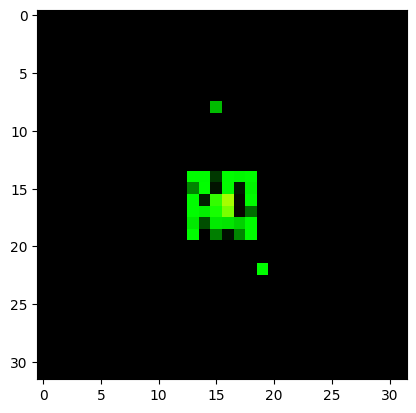

In [4]:
# -------------------------------------------------------
#                   Electron Plot
# -------------------------------------------------------


img = X_Electron[26500]
img = (img*255)
imgg = np.zeros((32,32,1))
img = np.dstack([img, imgg])
img = img.astype('uint8')
plt.imshow(img)

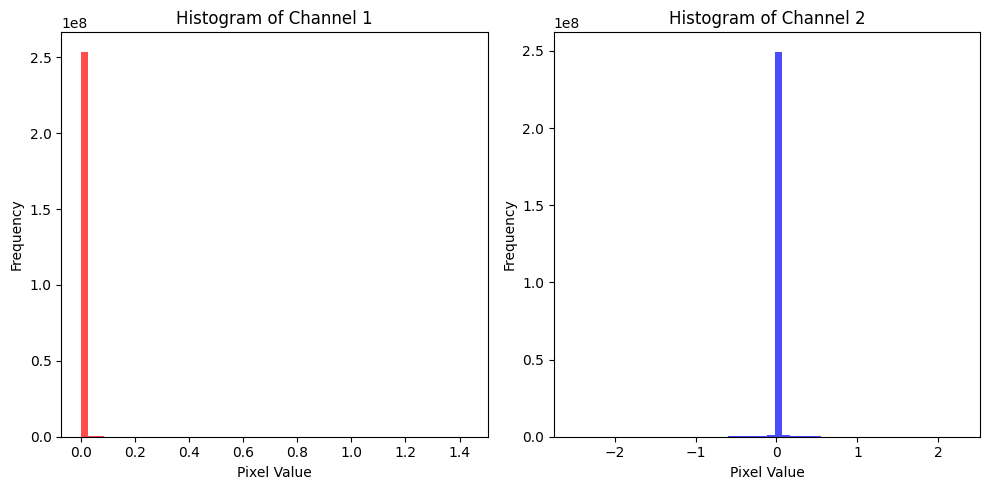

In [5]:
flattened_image = X_Electron.reshape((-1, 2))
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.hist(flattened_image[:, 0], bins=50, color='red', alpha=0.7)
plt.title('Histogram of Channel 1')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(flattened_image[:, 1], bins=50, color='blue', alpha=0.7)
plt.title('Histogram of Channel 2')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

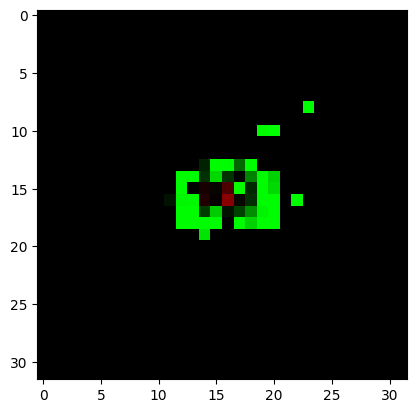

In [6]:
import matplotlib.pyplot as plt
img = X_Photon[0]
img = (img*255)
imgg = np.zeros((32,32,1))
img = np.dstack([img, imgg])
img = img.astype('uint8')
plt.imshow(img)

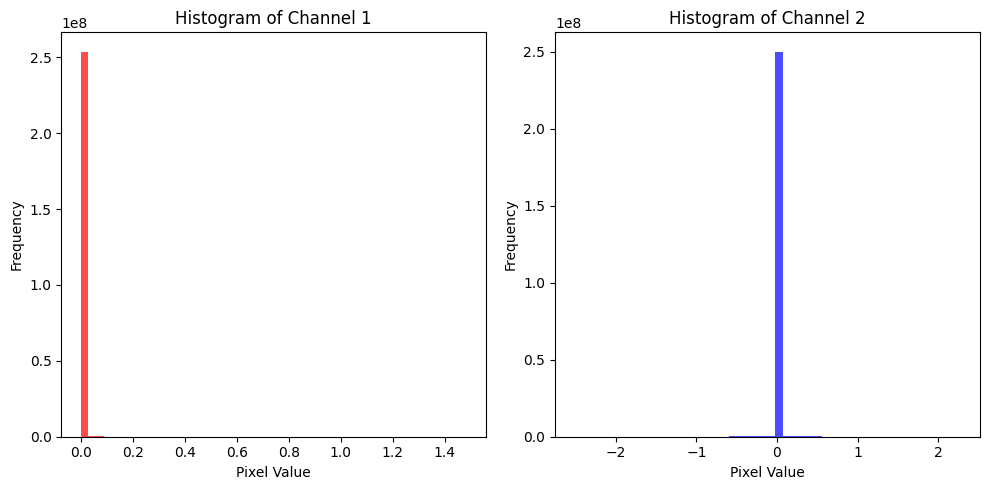

In [7]:
flattened_image = X_Photon.reshape((-1, 2))

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.hist(flattened_image[:, 0], bins=50, color='red', alpha=0.7)
plt.title('Histogram of Channel 1')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(flattened_image[:, 1], bins=50, color='blue', alpha=0.7)
plt.title('Histogram of Channel 2')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [8]:
X_train = np.concatenate((X_Electron, X_Photon), axis = 0)
X_train.shape

Y_train = np.concatenate((Y_Electron, Y_Photon))
Y_train.shape

(498000,)

In [9]:
import numpy as np

# Assuming X_train and Y_train are your data and labels arrays
combined = list(zip(X_train, Y_train))
np.random.shuffle(combined)
X_train_shuffled, Y_train_shuffled = zip(*combined)

# Convert back to numpy arrays if necessary
X_train_shuffled = np.array(X_train_shuffled)
Y_train_shuffled = np.array(Y_train_shuffled)

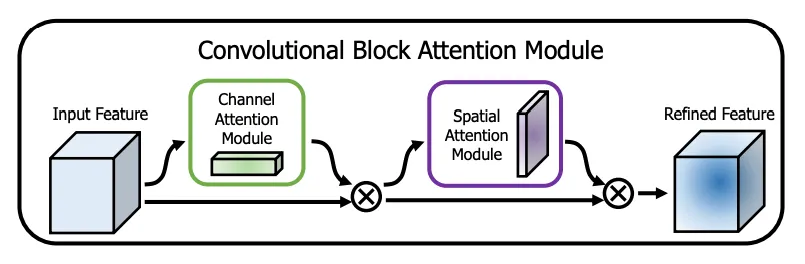

In [10]:
import torch
import math
import torch.nn as nn

class BasicConv(nn.Module):
    def __init__(self, in_planes, out_planes, kernel_size, stride=1, padding=0, dilation=1, groups=1, relu=True, bn=True, bias=False):
        super(BasicConv, self).__init__()
        self.out_channels = out_planes
        self.conv = nn.Conv2d(in_planes, out_planes, kernel_size=kernel_size, stride=stride, padding=padding, dilation=dilation, groups=groups, bias=bias)
        self.bn = nn.BatchNorm2d(out_planes,eps=1e-5, momentum=0.01, affine=True) if bn else None
        self.relu = nn.ReLU() if relu else None

    def forward(self, x):
        
        x = self.conv(x)
        
        if self.bn is not None:
            x = self.bn(x)
        if self.relu is not None:
            x = self.relu(x)
        return x

class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.size(0), -1)

class ChannelGate(nn.Module):
    def __init__(self, gate_channels, reduction_ratio=16):
        super(ChannelGate, self).__init__()
        
        # Number of input channels to image
        self.gate_channels = gate_channels
        
        #MLP layer
        self.mlp = nn.Sequential(
            Flatten(),
            nn.Linear(gate_channels, gate_channels // reduction_ratio),
            nn.ReLU(),
            nn.Linear(gate_channels // reduction_ratio, gate_channels)
            )

    def forward(self, x):
        
        #Avg_pool
        avg_pool = F.avg_pool2d( x, (x.size(2), x.size(3)), stride=(x.size(2), x.size(3)))
        channel_att_avg = self.mlp( avg_pool )

        #max_pool
        max_pool = F.max_pool2d( x, (x.size(2), x.size(3)), stride=(x.size(2), x.size(3)))
        channel_att_max = self.mlp( max_pool )

        #Element wise sum
        channel_att_sum = channel_att_max + channel_att_avg

        #scaling output of channel attention to match dimensions with input
        scale = F.sigmoid( channel_att_sum ).unsqueeze(2).unsqueeze(3).expand_as(x)
        
        return x * scale


class ChannelPool(nn.Module):
    def forward(self, x):
        return torch.cat( (torch.max(x,1)[0].unsqueeze(1), torch.mean(x,1).unsqueeze(1)), dim=1 )

class SpatialGate(nn.Module):
    def __init__(self):
        super(SpatialGate, self).__init__()
        kernel_size = 7
        self.compress = ChannelPool()
        self.spatial = BasicConv(2, 1, kernel_size, stride=1, padding=(kernel_size-1) // 2, relu=False)
        
    def forward(self, x):
        
        # Applying Average Pooling and Maxpooling layer and concatenating
        x_compress = self.compress(x)
        
        # Applying Convolution operation on concatenated inputs
        x_out = self.spatial(x_compress)
        
        # Applying Sigmoid to attention mask
        scale = F.sigmoid(x_out) # broadcasting
        
        return x * scale

class CBAM(nn.Module):
    def __init__(self, gate_channels, reduction_ratio=1, no_spatial=False):
        super(CBAM, self).__init__()
        self.ChannelGate = ChannelGate(gate_channels, reduction_ratio)
        self.no_spatial=no_spatial
        
        if not no_spatial:
            self.SpatialGate = SpatialGate()
            
    def forward(self, x):
        x_out = self.ChannelGate(x)
        if not self.no_spatial:
            x_out = self.SpatialGate(x_out)
        return x_out

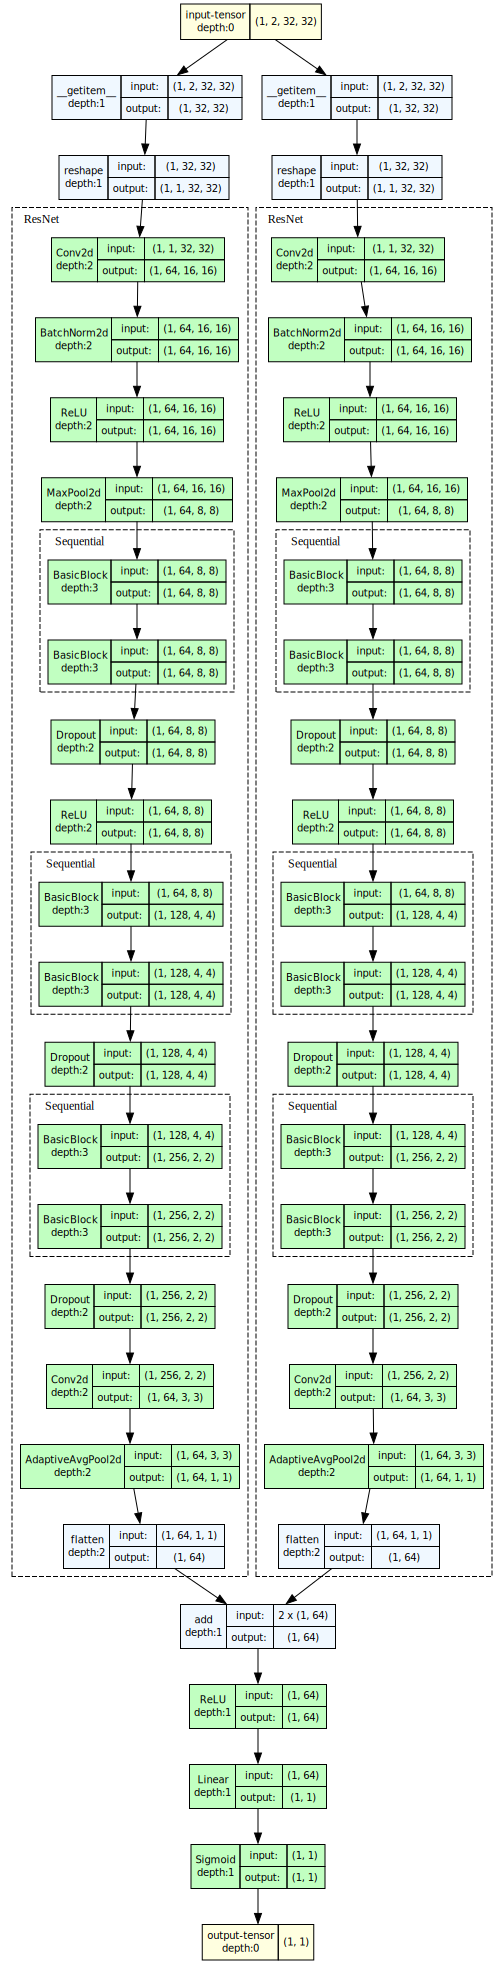

In [11]:
from torch import Tensor
from typing import Type

class BasicBlock(nn.Module):
    def __init__(self, in_channels: int,out_channels: int,stride: int = 1,expansion: int = 1,downsample: nn.Module = None) -> None:
        super(BasicBlock, self).__init__()
        self.expansion = expansion
        self.downsample = downsample
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1,bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels*self.expansion, kernel_size=3, padding=1,bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels*self.expansion)
        
    def forward(self, x: Tensor) -> Tensor:
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample is not None:
            identity = self.downsample(x)
        out += identity
        out = self.relu(out)
        return  out
    
class ResNet(nn.Module):
    def __init__(
        self, 
        img_channels: int,
        num_layers: int,
        block: Type[BasicBlock],
        cbam: Type[BasicBlock],
        num_classes: int  = 2
    ) -> None:
        super(ResNet, self).__init__()
        if num_layers == 15:
            # The following `layers` list defines the number of `BasicBlock` 
            # to use to build the network and how many basic blocks to stack
            # together.
            layers = [2, 2, 2, 2]
        self.expansion = 1
        self.in_channels = 64
        
        # All ResNets (18 to 152) contain a Conv2d => BN => ReLU for the first
        # three layers. Here, kernel size is 7.
        self.conv1 = nn.Conv2d(
            in_channels=1,
            out_channels=self.in_channels,
            kernel_size=7, 
            stride=2,
            padding=3,
            bias=False
        )
        self.conv2 = nn.Conv2d(
            in_channels=256,
            out_channels=64,
            kernel_size=3, 
            stride=2,
            padding=3,
            bias=False
        )
        
        self.bn1 = nn.BatchNorm2d(self.in_channels)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.cbam_1 = self.channel_block_attention(cbam)
        
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.cbam_2 = self.channel_block_attention(cbam)
        
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.cbam_3 = self.channel_block_attention(cbam)
        
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(64*self.expansion, 1)
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(p = 0.2)
        
    def _make_layer(
        self, 
        block: Type[BasicBlock],
        out_channels: int,
        blocks: int,
        stride: int = 1
    ) -> nn.Sequential:
        downsample = None
        if stride != 1:
            downsample = nn.Sequential(
                nn.Conv2d(
                    self.in_channels, 
                    out_channels*self.expansion,
                    kernel_size=1,
                    stride=stride,
                    bias=False 
                ),
                nn.BatchNorm2d(out_channels * self.expansion),
            )
        layers = []
        layers.append(
            block(
                self.in_channels, out_channels, stride, self.expansion, downsample
            )
        )
        self.in_channels = out_channels * self.expansion
        for i in range(1, blocks):
            layers.append(block(
                self.in_channels,
                out_channels,
                expansion=self.expansion
            ))
        return nn.Sequential(*layers)
    
    def channel_block_attention(self, cbam):
        return cbam(self.in_channels)
    
    def forward(self, x: Tensor) -> Tensor:
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        x = self.layer1(x)
        x = self.dropout(x)
        x = self.relu(x)
        
    
        x = self.layer2(x)
        x = self.dropout(x)
        
        x = self.layer3(x)
        x = self.dropout(x)
        
        x = self.conv2(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        return x
    
class Resnet_Ensemble(nn.Module):
    def __init__(self,img_channels:int,
                 num_layers: int,
                 block: Type[BasicBlock],
                 cbam: Type[CBAM],
                 resnet,
                 num_classes: int  = 2):
        
        super(Resnet_Ensemble, self).__init__()
        self.img_channels = img_channels
        self.num_layers = num_layers
        self.expansion = 1
        self.resnet_time = resnet(img_channels, num_layers, block, cbam)
        self.resnet_energy = resnet(img_channels, num_layers, block, cbam)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(64*self.expansion, 1)
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(p = 0.2)
        self.relu = nn.ReLU()
    
    def __make_layer(self, block):
        return 
    def forward(self, x):
        x_t = x[:,1,:,:]
        x_t = x_t.reshape((x_t.shape[0],1,x_t.shape[2], x_t.shape[2]))
        x_e = x[:,0,:,:]
        x_e = x_e.reshape((x_e.shape[0],1,x_e.shape[2], x_e.shape[2]))
        
        op_T = self.resnet_time(x_t)
        op_E = self.resnet_energy(x_e)
        
        op =  op_T+op_E
        op = self.relu(op)
        op = self.fc(op)
        op = self.sigmoid(op)
        return op
        
        
model = Resnet_Ensemble(2, 15, BasicBlock, CBAM, ResNet)
import torchvision
from torchview import draw_graph
from torchviz import make_dot

model_graph = draw_graph(model, input_size=(1,2,32,32), expand_nested=True)
model_graph.visual_graph

In [12]:
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode


class CustomDataset(Dataset):
    def __init__(self, x, y, transform = None):
        self.x = x
        self.y = y
        self.transform = transform
        
    def __len__(self):
        return self.x.shape[0]
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        img = self.x[idx]
        label = self.y[idx]
        label = torch.tensor(label).float().unsqueeze(0)
        if self.transform:
            img = self.transform(img)
        
        sample = {'image':img, 'labels' : label}
        
        return sample
            
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
dataset = CustomDataset(X_train_shuffled, Y_train_shuffled, transform = transform)

sample = dataset.__getitem__(0)
print(sample['image'].shape)
print(sample['labels'])

torch.Size([2, 32, 32])
tensor([0.])


In [13]:
from torchmetrics import Accuracy
import copy
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import tqdm
from tqdm import tqdm
from torchmetrics import Accuracy

def model_train(fold, model, epochs, train_dataloader, test_dataloader):
    # Loss function and optimizer
    criterion = nn.BCELoss()  # Binary Cross Entropy
    optimizer = optim.Adam(model.parameters(), lr=0.01)
#     optimizer = optimizer.to(DEVICE)
    accuracy = Accuracy(task = 'binary').to(DEVICE)
 
    # Hold the best model
    best_acc = -np.inf  # Init to negative infinity
    best_weights = None

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in tqdm(range(epochs), desc='Epochs', unit='epoch'):
        train_pred = []
        val_pred = []

        model.train()
        for batch in train_dataloader:
            images, labels = batch['image'], batch['labels']
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_pred.append(loss.item())

            # Calculate training accuracy
            train_acc = accuracy(outputs, labels)
            train_accuracies.append(train_acc.item())

        train_loss = np.mean(train_pred)

        model.eval()
        with torch.no_grad():
            for val_batch in test_dataloader:
                val_images, val_labels = val_batch['image'], val_batch['labels']
                val_images = val_images.to(DEVICE)
                val_labels = val_labels.to(DEVICE)

                val_outputs = model(val_images)
                val_loss = criterion(val_outputs, val_labels)
                val_pred.append(val_loss.item())

                # Calculate validation accuracy
                val_acc = accuracy(val_outputs, val_labels)
                val_accuracies.append(val_acc.item())

        val_loss = np.mean(val_pred)

        # Print and store losses and accuracies
        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {np.mean(train_accuracies):.4f}, Valid Loss: {val_loss:.4f}, Valid Accuracy: {np.mean(val_accuracies):.4f}')
        train_losses.append(train_loss)
        val_losses.append(val_loss)

        # Save best model
        if max(train_accuracies) > best_acc:
            best_acc = max(train_accuracies)
            best_weights = copy.deepcopy(model.state_dict())
            
#         model.load_state_dict(best_weights)
    
    # Save the best model
    torch.save(best_weights, f'./best_model_{fold}.pth')

    # Plot training and validation losses
    return train_losses, val_losses, train_accuracies, val_accuracies


In [14]:
# import timm
from torch.utils.data import Dataset, DataLoader,TensorDataset,random_split,SubsetRandomSampler, ConcatDataset
from sklearn.model_selection import KFold
k_folds = 5
batch_size = 256
kf = KFold(n_splits=k_folds, shuffle=True)
trn_fold_loss = []
val_fold_loss = []
for fold, (train_idx, test_idx) in enumerate(kf.split(dataset)):
    
    print(f'*** Fold {fold}***')
    print('Training Started.....')
    train_loader = DataLoader(dataset=dataset,
                              batch_size=batch_size,
                              sampler=torch.utils.data.SubsetRandomSampler(train_idx),
    )
    
    test_loader = DataLoader(dataset=dataset,
                             batch_size=batch_size,
                             sampler=torch.utils.data.SubsetRandomSampler(test_idx),
    )
    
    DEVICE = torch.device("cuda")
    model = Resnet_Ensemble(2, 15, BasicBlock, CBAM, resnet = ResNet)
    NUM_GPU = torch.cuda.device_count()
    if NUM_GPU > 1:
        model = nn.DataParallel(model)
    model = model.to(DEVICE)
    
    trn_loss, val_loss, trn_acc, val_acc = model_train(fold, model, epochs = 45, train_dataloader = train_loader, test_dataloader = test_loader)
    trn_fold_loss.append(trn_loss)
    val_fold_loss.append(val_loss)

*** Fold 0***
Training Started.....


Epochs:   2%|▏         | 1/45 [01:19<58:31, 79.80s/epoch]

Epoch 1/45, Train Loss: 0.5943, Train Accuracy: 0.6910, Valid Loss: 0.8532, Valid Accuracy: 0.6451


Epochs:   4%|▍         | 2/45 [02:39<57:12, 79.83s/epoch]

Epoch 2/45, Train Loss: 0.5636, Train Accuracy: 0.7045, Valid Loss: 0.5680, Valid Accuracy: 0.6786


Epochs:   7%|▋         | 3/45 [03:59<55:49, 79.76s/epoch]

Epoch 3/45, Train Loss: 0.5570, Train Accuracy: 0.7106, Valid Loss: 0.6160, Valid Accuracy: 0.6806


Epochs:   9%|▉         | 4/45 [05:18<54:26, 79.68s/epoch]

Epoch 4/45, Train Loss: 0.5531, Train Accuracy: 0.7142, Valid Loss: 0.5581, Valid Accuracy: 0.6913


Epochs:  11%|█         | 5/45 [06:38<53:03, 79.59s/epoch]

Epoch 5/45, Train Loss: 0.5502, Train Accuracy: 0.7168, Valid Loss: 0.5484, Valid Accuracy: 0.6992


Epochs:  13%|█▎        | 6/45 [07:58<51:45, 79.63s/epoch]

Epoch 6/45, Train Loss: 0.5488, Train Accuracy: 0.7186, Valid Loss: 0.5594, Valid Accuracy: 0.7041


Epochs:  16%|█▌        | 7/45 [09:18<50:30, 79.75s/epoch]

Epoch 7/45, Train Loss: 0.5464, Train Accuracy: 0.7201, Valid Loss: 0.5484, Valid Accuracy: 0.7078


Epochs:  18%|█▊        | 8/45 [10:37<49:07, 79.67s/epoch]

Epoch 8/45, Train Loss: 0.5451, Train Accuracy: 0.7214, Valid Loss: 0.5632, Valid Accuracy: 0.7087


Epochs:  20%|██        | 9/45 [11:56<47:45, 79.60s/epoch]

Epoch 9/45, Train Loss: 0.5443, Train Accuracy: 0.7225, Valid Loss: 0.5440, Valid Accuracy: 0.7111


Epochs:  22%|██▏       | 10/45 [13:16<46:26, 79.61s/epoch]

Epoch 10/45, Train Loss: 0.5428, Train Accuracy: 0.7234, Valid Loss: 0.5441, Valid Accuracy: 0.7132


Epochs:  24%|██▍       | 11/45 [14:36<45:13, 79.82s/epoch]

Epoch 11/45, Train Loss: 0.5419, Train Accuracy: 0.7242, Valid Loss: 0.5440, Valid Accuracy: 0.7147


Epochs:  27%|██▋       | 12/45 [15:57<44:05, 80.16s/epoch]

Epoch 12/45, Train Loss: 0.5410, Train Accuracy: 0.7250, Valid Loss: 0.5417, Valid Accuracy: 0.7164


Epochs:  29%|██▉       | 13/45 [17:18<42:53, 80.43s/epoch]

Epoch 13/45, Train Loss: 0.5399, Train Accuracy: 0.7257, Valid Loss: 0.5410, Valid Accuracy: 0.7177


Epochs:  31%|███       | 14/45 [18:40<41:40, 80.65s/epoch]

Epoch 14/45, Train Loss: 0.5391, Train Accuracy: 0.7263, Valid Loss: 0.5399, Valid Accuracy: 0.7190


Epochs:  33%|███▎      | 15/45 [20:00<40:19, 80.66s/epoch]

Epoch 15/45, Train Loss: 0.5385, Train Accuracy: 0.7269, Valid Loss: 0.5485, Valid Accuracy: 0.7201


Epochs:  36%|███▌      | 16/45 [21:22<39:09, 81.01s/epoch]

Epoch 16/45, Train Loss: 0.5380, Train Accuracy: 0.7274, Valid Loss: 0.5640, Valid Accuracy: 0.7194


Epochs:  38%|███▊      | 17/45 [22:42<37:39, 80.70s/epoch]

Epoch 17/45, Train Loss: 0.5370, Train Accuracy: 0.7279, Valid Loss: 0.5411, Valid Accuracy: 0.7202


Epochs:  40%|████      | 18/45 [24:03<36:20, 80.77s/epoch]

Epoch 18/45, Train Loss: 0.5369, Train Accuracy: 0.7284, Valid Loss: 0.5721, Valid Accuracy: 0.7191


Epochs:  42%|████▏     | 19/45 [25:24<35:03, 80.89s/epoch]

Epoch 19/45, Train Loss: 0.5358, Train Accuracy: 0.7288, Valid Loss: 0.5536, Valid Accuracy: 0.7193


Epochs:  44%|████▍     | 20/45 [26:45<33:44, 80.99s/epoch]

Epoch 20/45, Train Loss: 0.5356, Train Accuracy: 0.7292, Valid Loss: 0.5376, Valid Accuracy: 0.7200


Epochs:  47%|████▋     | 21/45 [28:05<32:13, 80.55s/epoch]

Epoch 21/45, Train Loss: 0.5348, Train Accuracy: 0.7295, Valid Loss: 0.5435, Valid Accuracy: 0.7205


Epochs:  49%|████▉     | 22/45 [29:24<30:41, 80.08s/epoch]

Epoch 22/45, Train Loss: 0.5343, Train Accuracy: 0.7299, Valid Loss: 0.5550, Valid Accuracy: 0.7205


Epochs:  51%|█████     | 23/45 [30:43<29:15, 79.81s/epoch]

Epoch 23/45, Train Loss: 0.5336, Train Accuracy: 0.7303, Valid Loss: 0.5444, Valid Accuracy: 0.7211


Epochs:  53%|█████▎    | 24/45 [32:03<27:59, 79.98s/epoch]

Epoch 24/45, Train Loss: 0.5334, Train Accuracy: 0.7306, Valid Loss: 0.5500, Valid Accuracy: 0.7215


Epochs:  56%|█████▌    | 25/45 [33:23<26:40, 80.00s/epoch]

Epoch 25/45, Train Loss: 0.5323, Train Accuracy: 0.7309, Valid Loss: 0.5394, Valid Accuracy: 0.7220


Epochs:  58%|█████▊    | 26/45 [34:42<25:14, 79.71s/epoch]

Epoch 26/45, Train Loss: 0.5318, Train Accuracy: 0.7313, Valid Loss: 0.5407, Valid Accuracy: 0.7226


Epochs:  60%|██████    | 27/45 [36:02<23:52, 79.60s/epoch]

Epoch 27/45, Train Loss: 0.5317, Train Accuracy: 0.7316, Valid Loss: 0.5351, Valid Accuracy: 0.7231


Epochs:  62%|██████▏   | 28/45 [37:22<22:36, 79.81s/epoch]

Epoch 28/45, Train Loss: 0.5311, Train Accuracy: 0.7319, Valid Loss: 0.5515, Valid Accuracy: 0.7236


Epochs:  64%|██████▍   | 29/45 [38:44<21:28, 80.55s/epoch]

Epoch 29/45, Train Loss: 0.5310, Train Accuracy: 0.7322, Valid Loss: 0.5488, Valid Accuracy: 0.7237


Epochs:  67%|██████▋   | 30/45 [40:05<20:07, 80.48s/epoch]

Epoch 30/45, Train Loss: 0.5299, Train Accuracy: 0.7324, Valid Loss: 0.5425, Valid Accuracy: 0.7240


Epochs:  69%|██████▉   | 31/45 [41:24<18:41, 80.12s/epoch]

Epoch 31/45, Train Loss: 0.5296, Train Accuracy: 0.7327, Valid Loss: 0.5347, Valid Accuracy: 0.7245


Epochs:  71%|███████   | 32/45 [42:44<17:20, 80.05s/epoch]

Epoch 32/45, Train Loss: 0.5287, Train Accuracy: 0.7330, Valid Loss: 0.5370, Valid Accuracy: 0.7248


Epochs:  73%|███████▎  | 33/45 [44:04<15:59, 79.95s/epoch]

Epoch 33/45, Train Loss: 0.5281, Train Accuracy: 0.7333, Valid Loss: 0.5372, Valid Accuracy: 0.7252


Epochs:  76%|███████▌  | 34/45 [45:23<14:36, 79.72s/epoch]

Epoch 34/45, Train Loss: 0.5276, Train Accuracy: 0.7335, Valid Loss: 0.5480, Valid Accuracy: 0.7253


Epochs:  78%|███████▊  | 35/45 [46:43<13:18, 79.85s/epoch]

Epoch 35/45, Train Loss: 0.5269, Train Accuracy: 0.7338, Valid Loss: 0.5357, Valid Accuracy: 0.7257


Epochs:  80%|████████  | 36/45 [48:04<12:00, 80.06s/epoch]

Epoch 36/45, Train Loss: 0.5261, Train Accuracy: 0.7341, Valid Loss: 0.5482, Valid Accuracy: 0.7258


Epochs:  82%|████████▏ | 37/45 [49:23<10:38, 79.80s/epoch]

Epoch 37/45, Train Loss: 0.5256, Train Accuracy: 0.7343, Valid Loss: 0.5375, Valid Accuracy: 0.7261


Epochs:  84%|████████▍ | 38/45 [50:42<09:17, 79.61s/epoch]

Epoch 38/45, Train Loss: 0.5247, Train Accuracy: 0.7345, Valid Loss: 0.5346, Valid Accuracy: 0.7264


Epochs:  87%|████████▋ | 39/45 [52:01<07:57, 79.58s/epoch]

Epoch 39/45, Train Loss: 0.5237, Train Accuracy: 0.7348, Valid Loss: 0.5339, Valid Accuracy: 0.7268


Epochs:  89%|████████▉ | 40/45 [53:21<06:37, 79.56s/epoch]

Epoch 40/45, Train Loss: 0.5232, Train Accuracy: 0.7350, Valid Loss: 0.5463, Valid Accuracy: 0.7270


Epochs:  91%|█████████ | 41/45 [54:40<05:17, 79.48s/epoch]

Epoch 41/45, Train Loss: 0.5222, Train Accuracy: 0.7353, Valid Loss: 0.5638, Valid Accuracy: 0.7267


Epochs:  93%|█████████▎| 42/45 [55:59<03:58, 79.38s/epoch]

Epoch 42/45, Train Loss: 0.5218, Train Accuracy: 0.7355, Valid Loss: 0.5410, Valid Accuracy: 0.7270


Epochs:  96%|█████████▌| 43/45 [57:19<02:39, 79.50s/epoch]

Epoch 43/45, Train Loss: 0.5207, Train Accuracy: 0.7357, Valid Loss: 0.5352, Valid Accuracy: 0.7273


Epochs:  98%|█████████▊| 44/45 [58:41<01:20, 80.20s/epoch]

Epoch 44/45, Train Loss: 0.5202, Train Accuracy: 0.7359, Valid Loss: 0.5362, Valid Accuracy: 0.7276


Epochs: 100%|██████████| 45/45 [1:00:03<00:00, 80.08s/epoch]

Epoch 45/45, Train Loss: 0.5191, Train Accuracy: 0.7361, Valid Loss: 0.5423, Valid Accuracy: 0.7278
*** Fold 1***
Training Started.....



Epochs:   2%|▏         | 1/45 [01:21<1:00:01, 81.86s/epoch]

Epoch 1/45, Train Loss: 0.5971, Train Accuracy: 0.6896, Valid Loss: 0.5783, Valid Accuracy: 0.7102


Epochs:   4%|▍         | 2/45 [02:44<58:53, 82.18s/epoch]  

Epoch 2/45, Train Loss: 0.5667, Train Accuracy: 0.7033, Valid Loss: 0.6819, Valid Accuracy: 0.6572


Epochs:   7%|▋         | 3/45 [04:06<57:25, 82.04s/epoch]

Epoch 3/45, Train Loss: 0.5586, Train Accuracy: 0.7097, Valid Loss: 0.6649, Valid Accuracy: 0.6640


Epochs:   9%|▉         | 4/45 [05:28<56:06, 82.12s/epoch]

Epoch 4/45, Train Loss: 0.5549, Train Accuracy: 0.7134, Valid Loss: 0.5554, Valid Accuracy: 0.6787


Epochs:  11%|█         | 5/45 [06:50<54:49, 82.23s/epoch]

Epoch 5/45, Train Loss: 0.5517, Train Accuracy: 0.7161, Valid Loss: 0.5502, Valid Accuracy: 0.6879


Epochs:  13%|█▎        | 6/45 [08:13<53:33, 82.39s/epoch]

Epoch 6/45, Train Loss: 0.5497, Train Accuracy: 0.7180, Valid Loss: 0.5782, Valid Accuracy: 0.6895


Epochs:  16%|█▌        | 7/45 [09:35<52:11, 82.41s/epoch]

Epoch 7/45, Train Loss: 0.5473, Train Accuracy: 0.7196, Valid Loss: 0.5692, Valid Accuracy: 0.6911


Epochs:  18%|█▊        | 8/45 [10:58<50:51, 82.46s/epoch]

Epoch 8/45, Train Loss: 0.5463, Train Accuracy: 0.7209, Valid Loss: 0.5847, Valid Accuracy: 0.6922


Epochs:  20%|██        | 9/45 [12:21<49:32, 82.56s/epoch]

Epoch 9/45, Train Loss: 0.5452, Train Accuracy: 0.7221, Valid Loss: 0.5516, Valid Accuracy: 0.6957


Epochs:  22%|██▏       | 10/45 [13:44<48:13, 82.68s/epoch]

Epoch 10/45, Train Loss: 0.5433, Train Accuracy: 0.7231, Valid Loss: 0.5420, Valid Accuracy: 0.6992


Epochs:  24%|██▍       | 11/45 [15:07<46:55, 82.81s/epoch]

Epoch 11/45, Train Loss: 0.5429, Train Accuracy: 0.7240, Valid Loss: 0.5463, Valid Accuracy: 0.7016


Epochs:  27%|██▋       | 12/45 [16:30<45:33, 82.85s/epoch]

Epoch 12/45, Train Loss: 0.5419, Train Accuracy: 0.7247, Valid Loss: 0.5388, Valid Accuracy: 0.7043


Epochs:  29%|██▉       | 13/45 [17:53<44:14, 82.96s/epoch]

Epoch 13/45, Train Loss: 0.5407, Train Accuracy: 0.7255, Valid Loss: 0.5371, Valid Accuracy: 0.7067


Epochs:  31%|███       | 14/45 [19:16<42:51, 82.95s/epoch]

Epoch 14/45, Train Loss: 0.5402, Train Accuracy: 0.7261, Valid Loss: 0.5420, Valid Accuracy: 0.7084


Epochs:  33%|███▎      | 15/45 [20:39<41:25, 82.83s/epoch]

Epoch 15/45, Train Loss: 0.5393, Train Accuracy: 0.7267, Valid Loss: 0.5403, Valid Accuracy: 0.7101


Epochs:  36%|███▌      | 16/45 [22:01<40:03, 82.88s/epoch]

Epoch 16/45, Train Loss: 0.5385, Train Accuracy: 0.7272, Valid Loss: 0.8309, Valid Accuracy: 0.6994


Epochs:  38%|███▊      | 17/45 [23:25<38:44, 83.01s/epoch]

Epoch 17/45, Train Loss: 0.5378, Train Accuracy: 0.7277, Valid Loss: 0.5399, Valid Accuracy: 0.7014


Epochs:  40%|████      | 18/45 [24:48<37:24, 83.12s/epoch]

Epoch 18/45, Train Loss: 0.5370, Train Accuracy: 0.7282, Valid Loss: 0.5687, Valid Accuracy: 0.7023


Epochs:  42%|████▏     | 19/45 [26:11<35:59, 83.05s/epoch]

Epoch 19/45, Train Loss: 0.5365, Train Accuracy: 0.7286, Valid Loss: 0.5342, Valid Accuracy: 0.7041


Epochs:  44%|████▍     | 20/45 [27:34<34:33, 82.93s/epoch]

Epoch 20/45, Train Loss: 0.5355, Train Accuracy: 0.7290, Valid Loss: 0.5369, Valid Accuracy: 0.7057


Epochs:  47%|████▋     | 21/45 [28:56<33:06, 82.75s/epoch]

Epoch 21/45, Train Loss: 0.5349, Train Accuracy: 0.7294, Valid Loss: 0.5889, Valid Accuracy: 0.7053


Epochs:  49%|████▉     | 22/45 [30:18<31:39, 82.59s/epoch]

Epoch 22/45, Train Loss: 0.5337, Train Accuracy: 0.7298, Valid Loss: 0.5366, Valid Accuracy: 0.7068


Epochs:  51%|█████     | 23/45 [31:42<30:22, 82.85s/epoch]

Epoch 23/45, Train Loss: 0.5330, Train Accuracy: 0.7302, Valid Loss: 0.5590, Valid Accuracy: 0.7072


Epochs:  53%|█████▎    | 24/45 [33:04<28:56, 82.69s/epoch]

Epoch 24/45, Train Loss: 0.5323, Train Accuracy: 0.7306, Valid Loss: 0.5358, Valid Accuracy: 0.7084


Epochs:  56%|█████▌    | 25/45 [34:27<27:33, 82.70s/epoch]

Epoch 25/45, Train Loss: 0.5311, Train Accuracy: 0.7309, Valid Loss: 0.5659, Valid Accuracy: 0.7084


Epochs:  58%|█████▊    | 26/45 [35:50<26:11, 82.73s/epoch]

Epoch 26/45, Train Loss: 0.5305, Train Accuracy: 0.7313, Valid Loss: 0.5376, Valid Accuracy: 0.7095


Epochs:  60%|██████    | 27/45 [37:12<24:47, 82.61s/epoch]

Epoch 27/45, Train Loss: 0.5297, Train Accuracy: 0.7317, Valid Loss: 0.5383, Valid Accuracy: 0.7105


Epochs:  62%|██████▏   | 28/45 [38:35<23:24, 82.62s/epoch]

Epoch 28/45, Train Loss: 0.5291, Train Accuracy: 0.7320, Valid Loss: 0.5417, Valid Accuracy: 0.7112


Epochs:  64%|██████▍   | 29/45 [39:57<22:02, 82.66s/epoch]

Epoch 29/45, Train Loss: 0.5281, Train Accuracy: 0.7323, Valid Loss: 0.5415, Valid Accuracy: 0.7119


Epochs:  67%|██████▋   | 30/45 [41:20<20:40, 82.72s/epoch]

Epoch 30/45, Train Loss: 0.5269, Train Accuracy: 0.7327, Valid Loss: 0.5505, Valid Accuracy: 0.7123


Epochs:  69%|██████▉   | 31/45 [42:42<19:16, 82.59s/epoch]

Epoch 31/45, Train Loss: 0.5260, Train Accuracy: 0.7330, Valid Loss: 0.5408, Valid Accuracy: 0.7130


Epochs:  71%|███████   | 32/45 [44:05<17:53, 82.59s/epoch]

Epoch 32/45, Train Loss: 0.5250, Train Accuracy: 0.7333, Valid Loss: 0.5678, Valid Accuracy: 0.7129


Epochs:  73%|███████▎  | 33/45 [45:28<16:31, 82.66s/epoch]

Epoch 33/45, Train Loss: 0.5245, Train Accuracy: 0.7336, Valid Loss: 0.5628, Valid Accuracy: 0.7131


Epochs:  76%|███████▌  | 34/45 [46:51<15:10, 82.77s/epoch]

Epoch 34/45, Train Loss: 0.5229, Train Accuracy: 0.7339, Valid Loss: 0.5420, Valid Accuracy: 0.7138


Epochs:  78%|███████▊  | 35/45 [48:14<13:50, 83.01s/epoch]

Epoch 35/45, Train Loss: 0.5223, Train Accuracy: 0.7343, Valid Loss: 0.5482, Valid Accuracy: 0.7142


Epochs:  80%|████████  | 36/45 [49:38<12:27, 83.06s/epoch]

Epoch 36/45, Train Loss: 0.5211, Train Accuracy: 0.7346, Valid Loss: 0.5412, Valid Accuracy: 0.7147


Epochs:  82%|████████▏ | 37/45 [51:01<11:05, 83.16s/epoch]

Epoch 37/45, Train Loss: 0.5199, Train Accuracy: 0.7349, Valid Loss: 0.5436, Valid Accuracy: 0.7153


Epochs:  84%|████████▍ | 38/45 [52:24<09:42, 83.25s/epoch]

Epoch 38/45, Train Loss: 0.5184, Train Accuracy: 0.7352, Valid Loss: 0.5449, Valid Accuracy: 0.7159


Epochs:  87%|████████▋ | 39/45 [53:47<08:18, 83.02s/epoch]

Epoch 39/45, Train Loss: 0.5179, Train Accuracy: 0.7355, Valid Loss: 0.6299, Valid Accuracy: 0.7148


Epochs:  89%|████████▉ | 40/45 [55:10<06:54, 82.89s/epoch]

Epoch 40/45, Train Loss: 0.5164, Train Accuracy: 0.7358, Valid Loss: 0.5488, Valid Accuracy: 0.7154


Epochs:  91%|█████████ | 41/45 [56:33<05:32, 83.08s/epoch]

Epoch 41/45, Train Loss: 0.5151, Train Accuracy: 0.7361, Valid Loss: 0.5572, Valid Accuracy: 0.7157


Epochs:  93%|█████████▎| 42/45 [57:56<04:09, 83.08s/epoch]

Epoch 42/45, Train Loss: 0.5137, Train Accuracy: 0.7364, Valid Loss: 0.5525, Valid Accuracy: 0.7161


Epochs:  96%|█████████▌| 43/45 [59:20<02:46, 83.20s/epoch]

Epoch 43/45, Train Loss: 0.5126, Train Accuracy: 0.7367, Valid Loss: 0.5505, Valid Accuracy: 0.7165


Epochs:  98%|█████████▊| 44/45 [1:00:42<01:23, 83.03s/epoch]

Epoch 44/45, Train Loss: 0.5115, Train Accuracy: 0.7370, Valid Loss: 0.5712, Valid Accuracy: 0.7167


Epochs: 100%|██████████| 45/45 [1:02:05<00:00, 82.79s/epoch]

Epoch 45/45, Train Loss: 0.5097, Train Accuracy: 0.7374, Valid Loss: 0.5509, Valid Accuracy: 0.7171
*** Fold 2***
Training Started.....



Epochs:   2%|▏         | 1/45 [01:22<1:00:36, 82.64s/epoch]

Epoch 1/45, Train Loss: 0.5950, Train Accuracy: 0.6910, Valid Loss: 0.5791, Valid Accuracy: 0.7110


Epochs:   4%|▍         | 2/45 [02:44<59:06, 82.47s/epoch]  

Epoch 2/45, Train Loss: 0.5656, Train Accuracy: 0.7041, Valid Loss: 0.6255, Valid Accuracy: 0.6893


Epochs:   7%|▋         | 3/45 [04:07<57:51, 82.64s/epoch]

Epoch 3/45, Train Loss: 0.5582, Train Accuracy: 0.7100, Valid Loss: 0.5702, Valid Accuracy: 0.6960


Epochs:   9%|▉         | 4/45 [05:30<56:32, 82.75s/epoch]

Epoch 4/45, Train Loss: 0.5537, Train Accuracy: 0.7139, Valid Loss: 0.6060, Valid Accuracy: 0.6968


Epochs:  11%|█         | 5/45 [06:53<55:15, 82.88s/epoch]

Epoch 5/45, Train Loss: 0.5506, Train Accuracy: 0.7165, Valid Loss: 0.5578, Valid Accuracy: 0.7015


Epochs:  13%|█▎        | 6/45 [08:17<54:00, 83.09s/epoch]

Epoch 6/45, Train Loss: 0.5483, Train Accuracy: 0.7185, Valid Loss: 0.6235, Valid Accuracy: 0.6985


Epochs:  16%|█▌        | 7/45 [09:40<52:33, 82.98s/epoch]

Epoch 7/45, Train Loss: 0.5458, Train Accuracy: 0.7202, Valid Loss: 0.5803, Valid Accuracy: 0.6987


Epochs:  18%|█▊        | 8/45 [11:02<51:06, 82.88s/epoch]

Epoch 8/45, Train Loss: 0.5439, Train Accuracy: 0.7217, Valid Loss: 0.5523, Valid Accuracy: 0.7021


Epochs:  20%|██        | 9/45 [12:25<49:40, 82.80s/epoch]

Epoch 9/45, Train Loss: 0.5428, Train Accuracy: 0.7229, Valid Loss: 0.5573, Valid Accuracy: 0.7037


Epochs:  22%|██▏       | 10/45 [13:47<48:15, 82.72s/epoch]

Epoch 10/45, Train Loss: 0.5413, Train Accuracy: 0.7240, Valid Loss: 0.5515, Valid Accuracy: 0.7058


Epochs:  24%|██▍       | 11/45 [15:10<46:54, 82.77s/epoch]

Epoch 11/45, Train Loss: 0.5403, Train Accuracy: 0.7249, Valid Loss: 0.5567, Valid Accuracy: 0.7071


Epochs:  27%|██▋       | 12/45 [16:33<45:32, 82.80s/epoch]

Epoch 12/45, Train Loss: 0.5394, Train Accuracy: 0.7257, Valid Loss: 0.5836, Valid Accuracy: 0.7059


Epochs:  29%|██▉       | 13/45 [17:56<44:05, 82.69s/epoch]

Epoch 13/45, Train Loss: 0.5388, Train Accuracy: 0.7264, Valid Loss: 0.5440, Valid Accuracy: 0.7080


Epochs:  31%|███       | 14/45 [19:17<42:30, 82.29s/epoch]

Epoch 14/45, Train Loss: 0.5378, Train Accuracy: 0.7270, Valid Loss: 0.5892, Valid Accuracy: 0.7057


Epochs:  33%|███▎      | 15/45 [20:39<41:08, 82.28s/epoch]

Epoch 15/45, Train Loss: 0.5369, Train Accuracy: 0.7276, Valid Loss: 0.9717, Valid Accuracy: 0.6940


Epochs:  36%|███▌      | 16/45 [22:01<39:45, 82.26s/epoch]

Epoch 16/45, Train Loss: 0.5361, Train Accuracy: 0.7282, Valid Loss: 0.5424, Valid Accuracy: 0.6966


Epochs:  38%|███▊      | 17/45 [23:24<38:21, 82.20s/epoch]

Epoch 17/45, Train Loss: 0.5349, Train Accuracy: 0.7288, Valid Loss: 0.5479, Valid Accuracy: 0.6983


Epochs:  40%|████      | 18/45 [24:44<36:49, 81.82s/epoch]

Epoch 18/45, Train Loss: 0.5344, Train Accuracy: 0.7293, Valid Loss: 0.5455, Valid Accuracy: 0.7001


Epochs:  42%|████▏     | 19/45 [26:06<35:27, 81.84s/epoch]

Epoch 19/45, Train Loss: 0.5339, Train Accuracy: 0.7298, Valid Loss: 0.5466, Valid Accuracy: 0.7015


Epochs:  44%|████▍     | 20/45 [27:29<34:08, 81.94s/epoch]

Epoch 20/45, Train Loss: 0.5335, Train Accuracy: 0.7302, Valid Loss: 0.5676, Valid Accuracy: 0.7025


Epochs:  47%|████▋     | 21/45 [28:51<32:47, 81.98s/epoch]

Epoch 21/45, Train Loss: 0.5326, Train Accuracy: 0.7306, Valid Loss: 0.6269, Valid Accuracy: 0.6998


Epochs:  49%|████▉     | 22/45 [30:13<31:26, 82.01s/epoch]

Epoch 22/45, Train Loss: 0.5318, Train Accuracy: 0.7310, Valid Loss: 0.6018, Valid Accuracy: 0.6982


Epochs:  51%|█████     | 23/45 [31:34<29:57, 81.69s/epoch]

Epoch 23/45, Train Loss: 0.5310, Train Accuracy: 0.7314, Valid Loss: 0.6402, Valid Accuracy: 0.6959


Epochs:  53%|█████▎    | 24/45 [32:55<28:31, 81.49s/epoch]

Epoch 24/45, Train Loss: 0.5303, Train Accuracy: 0.7318, Valid Loss: 0.5413, Valid Accuracy: 0.6974


Epochs:  56%|█████▌    | 25/45 [34:15<27:03, 81.19s/epoch]

Epoch 25/45, Train Loss: 0.5294, Train Accuracy: 0.7321, Valid Loss: 0.5827, Valid Accuracy: 0.6974


Epochs:  58%|█████▊    | 26/45 [35:36<25:41, 81.14s/epoch]

Epoch 26/45, Train Loss: 0.5282, Train Accuracy: 0.7325, Valid Loss: 0.5545, Valid Accuracy: 0.6987


Epochs:  60%|██████    | 27/45 [36:58<24:24, 81.34s/epoch]

Epoch 27/45, Train Loss: 0.5280, Train Accuracy: 0.7328, Valid Loss: 0.5441, Valid Accuracy: 0.6999


Epochs:  62%|██████▏   | 28/45 [38:19<23:02, 81.31s/epoch]

Epoch 28/45, Train Loss: 0.5273, Train Accuracy: 0.7331, Valid Loss: 0.5468, Valid Accuracy: 0.7012


Epochs:  64%|██████▍   | 29/45 [39:40<21:38, 81.14s/epoch]

Epoch 29/45, Train Loss: 0.5268, Train Accuracy: 0.7334, Valid Loss: 0.5448, Valid Accuracy: 0.7022


Epochs:  67%|██████▋   | 30/45 [41:01<20:16, 81.10s/epoch]

Epoch 30/45, Train Loss: 0.5259, Train Accuracy: 0.7338, Valid Loss: 0.6080, Valid Accuracy: 0.7012


Epochs:  69%|██████▉   | 31/45 [42:22<18:55, 81.11s/epoch]

Epoch 31/45, Train Loss: 0.5251, Train Accuracy: 0.7340, Valid Loss: 0.5443, Valid Accuracy: 0.7022


Epochs:  71%|███████   | 32/45 [43:43<17:35, 81.16s/epoch]

Epoch 32/45, Train Loss: 0.5244, Train Accuracy: 0.7343, Valid Loss: 0.5456, Valid Accuracy: 0.7031


Epochs:  73%|███████▎  | 33/45 [45:04<16:12, 81.08s/epoch]

Epoch 33/45, Train Loss: 0.5238, Train Accuracy: 0.7346, Valid Loss: 0.6125, Valid Accuracy: 0.7019


Epochs:  76%|███████▌  | 34/45 [46:25<14:50, 80.98s/epoch]

Epoch 34/45, Train Loss: 0.5230, Train Accuracy: 0.7349, Valid Loss: 0.5512, Valid Accuracy: 0.7025


Epochs:  78%|███████▊  | 35/45 [47:46<13:29, 80.93s/epoch]

Epoch 35/45, Train Loss: 0.5222, Train Accuracy: 0.7352, Valid Loss: 0.5430, Valid Accuracy: 0.7035


Epochs:  80%|████████  | 36/45 [49:08<12:11, 81.27s/epoch]

Epoch 36/45, Train Loss: 0.5213, Train Accuracy: 0.7354, Valid Loss: 0.5932, Valid Accuracy: 0.7032


Epochs:  82%|████████▏ | 37/45 [50:29<10:49, 81.25s/epoch]

Epoch 37/45, Train Loss: 0.5206, Train Accuracy: 0.7356, Valid Loss: 0.5402, Valid Accuracy: 0.7041


Epochs:  84%|████████▍ | 38/45 [51:50<09:28, 81.23s/epoch]

Epoch 38/45, Train Loss: 0.5195, Train Accuracy: 0.7359, Valid Loss: 0.5667, Valid Accuracy: 0.7045


Epochs:  87%|████████▋ | 39/45 [53:11<08:07, 81.18s/epoch]

Epoch 39/45, Train Loss: 0.5189, Train Accuracy: 0.7361, Valid Loss: 0.5387, Valid Accuracy: 0.7053


Epochs:  89%|████████▉ | 40/45 [54:32<06:45, 81.04s/epoch]

Epoch 40/45, Train Loss: 0.5173, Train Accuracy: 0.7364, Valid Loss: 0.5632, Valid Accuracy: 0.7056


Epochs:  91%|█████████ | 41/45 [55:53<05:23, 80.94s/epoch]

Epoch 41/45, Train Loss: 0.5163, Train Accuracy: 0.7366, Valid Loss: 0.6516, Valid Accuracy: 0.7044


Epochs:  93%|█████████▎| 42/45 [57:14<04:02, 80.95s/epoch]

Epoch 42/45, Train Loss: 0.5154, Train Accuracy: 0.7369, Valid Loss: 0.5473, Valid Accuracy: 0.7051


Epochs:  96%|█████████▌| 43/45 [58:35<02:42, 81.10s/epoch]

Epoch 43/45, Train Loss: 0.5143, Train Accuracy: 0.7371, Valid Loss: 0.7681, Valid Accuracy: 0.7017


Epochs:  98%|█████████▊| 44/45 [59:56<01:21, 81.17s/epoch]

Epoch 44/45, Train Loss: 0.5134, Train Accuracy: 0.7373, Valid Loss: 0.5637, Valid Accuracy: 0.7021


Epochs: 100%|██████████| 45/45 [1:01:18<00:00, 81.74s/epoch]

Epoch 45/45, Train Loss: 0.5124, Train Accuracy: 0.7375, Valid Loss: 0.5472, Valid Accuracy: 0.7028
*** Fold 3***
Training Started.....



Epochs:   2%|▏         | 1/45 [01:20<59:21, 80.95s/epoch]

Epoch 1/45, Train Loss: 0.5942, Train Accuracy: 0.6933, Valid Loss: 0.5880, Valid Accuracy: 0.7118


Epochs:   4%|▍         | 2/45 [02:41<58:01, 80.97s/epoch]

Epoch 2/45, Train Loss: 0.5656, Train Accuracy: 0.7054, Valid Loss: 0.5583, Valid Accuracy: 0.7158


Epochs:   7%|▋         | 3/45 [04:02<56:39, 80.94s/epoch]

Epoch 3/45, Train Loss: 0.5576, Train Accuracy: 0.7111, Valid Loss: 0.5594, Valid Accuracy: 0.7154


Epochs:   9%|▉         | 4/45 [05:23<55:14, 80.84s/epoch]

Epoch 4/45, Train Loss: 0.5533, Train Accuracy: 0.7146, Valid Loss: 0.5505, Valid Accuracy: 0.7187


Epochs:  11%|█         | 5/45 [06:44<53:55, 80.90s/epoch]

Epoch 5/45, Train Loss: 0.5509, Train Accuracy: 0.7172, Valid Loss: 0.5658, Valid Accuracy: 0.7190


Epochs:  13%|█▎        | 6/45 [08:05<52:36, 80.95s/epoch]

Epoch 6/45, Train Loss: 0.5480, Train Accuracy: 0.7193, Valid Loss: 0.5494, Valid Accuracy: 0.7207


Epochs:  16%|█▌        | 7/45 [09:26<51:15, 80.93s/epoch]

Epoch 7/45, Train Loss: 0.5464, Train Accuracy: 0.7209, Valid Loss: 0.5724, Valid Accuracy: 0.7190


Epochs:  18%|█▊        | 8/45 [10:47<49:54, 80.93s/epoch]

Epoch 8/45, Train Loss: 0.5447, Train Accuracy: 0.7222, Valid Loss: 0.5494, Valid Accuracy: 0.7198


Epochs:  20%|██        | 9/45 [12:08<48:35, 80.99s/epoch]

Epoch 9/45, Train Loss: 0.5437, Train Accuracy: 0.7233, Valid Loss: 0.5417, Valid Accuracy: 0.7212


Epochs:  22%|██▏       | 10/45 [13:29<47:14, 80.97s/epoch]

Epoch 10/45, Train Loss: 0.5424, Train Accuracy: 0.7243, Valid Loss: 0.5734, Valid Accuracy: 0.7190


Epochs:  24%|██▍       | 11/45 [14:50<45:52, 80.96s/epoch]

Epoch 11/45, Train Loss: 0.5415, Train Accuracy: 0.7251, Valid Loss: 0.5674, Valid Accuracy: 0.7171


Epochs:  27%|██▋       | 12/45 [16:11<44:31, 80.94s/epoch]

Epoch 12/45, Train Loss: 0.5404, Train Accuracy: 0.7259, Valid Loss: 0.6685, Valid Accuracy: 0.7083


Epochs:  29%|██▉       | 13/45 [17:33<43:23, 81.35s/epoch]

Epoch 13/45, Train Loss: 0.5395, Train Accuracy: 0.7266, Valid Loss: 0.5449, Valid Accuracy: 0.7099


Epochs:  31%|███       | 14/45 [18:55<42:02, 81.39s/epoch]

Epoch 14/45, Train Loss: 0.5386, Train Accuracy: 0.7272, Valid Loss: 0.5721, Valid Accuracy: 0.7099


Epochs:  33%|███▎      | 15/45 [20:16<40:38, 81.29s/epoch]

Epoch 15/45, Train Loss: 0.5380, Train Accuracy: 0.7278, Valid Loss: 0.5403, Valid Accuracy: 0.7115


Epochs:  36%|███▌      | 16/45 [21:37<39:15, 81.22s/epoch]

Epoch 16/45, Train Loss: 0.5371, Train Accuracy: 0.7283, Valid Loss: 0.5809, Valid Accuracy: 0.7102


Epochs:  38%|███▊      | 17/45 [22:58<37:54, 81.24s/epoch]

Epoch 17/45, Train Loss: 0.5364, Train Accuracy: 0.7288, Valid Loss: 0.5423, Valid Accuracy: 0.7114


Epochs:  40%|████      | 18/45 [24:19<36:30, 81.15s/epoch]

Epoch 18/45, Train Loss: 0.5358, Train Accuracy: 0.7293, Valid Loss: 0.5471, Valid Accuracy: 0.7124


Epochs:  42%|████▏     | 19/45 [25:40<35:06, 81.02s/epoch]

Epoch 19/45, Train Loss: 0.5349, Train Accuracy: 0.7297, Valid Loss: 0.5457, Valid Accuracy: 0.7134


Epochs:  44%|████▍     | 20/45 [27:01<33:46, 81.04s/epoch]

Epoch 20/45, Train Loss: 0.5340, Train Accuracy: 0.7301, Valid Loss: 0.6640, Valid Accuracy: 0.7101


Epochs:  47%|████▋     | 21/45 [28:22<32:25, 81.08s/epoch]

Epoch 21/45, Train Loss: 0.5334, Train Accuracy: 0.7305, Valid Loss: 0.5425, Valid Accuracy: 0.7110


Epochs:  49%|████▉     | 22/45 [29:43<31:03, 81.03s/epoch]

Epoch 22/45, Train Loss: 0.5330, Train Accuracy: 0.7309, Valid Loss: 0.5476, Valid Accuracy: 0.7118


Epochs:  51%|█████     | 23/45 [31:04<29:41, 80.96s/epoch]

Epoch 23/45, Train Loss: 0.5321, Train Accuracy: 0.7313, Valid Loss: 0.5395, Valid Accuracy: 0.7127


Epochs:  53%|█████▎    | 24/45 [32:25<28:21, 81.01s/epoch]

Epoch 24/45, Train Loss: 0.5316, Train Accuracy: 0.7316, Valid Loss: 0.5421, Valid Accuracy: 0.7137


Epochs:  56%|█████▌    | 25/45 [33:46<27:00, 81.02s/epoch]

Epoch 25/45, Train Loss: 0.5306, Train Accuracy: 0.7319, Valid Loss: 0.5356, Valid Accuracy: 0.7146


Epochs:  58%|█████▊    | 26/45 [35:07<25:38, 80.97s/epoch]

Epoch 26/45, Train Loss: 0.5299, Train Accuracy: 0.7322, Valid Loss: 0.5387, Valid Accuracy: 0.7153


Epochs:  60%|██████    | 27/45 [36:27<24:16, 80.94s/epoch]

Epoch 27/45, Train Loss: 0.5291, Train Accuracy: 0.7326, Valid Loss: 0.5443, Valid Accuracy: 0.7161


Epochs:  62%|██████▏   | 28/45 [37:49<22:57, 81.01s/epoch]

Epoch 28/45, Train Loss: 0.5289, Train Accuracy: 0.7329, Valid Loss: 0.5436, Valid Accuracy: 0.7168


Epochs:  64%|██████▍   | 29/45 [39:10<21:37, 81.07s/epoch]

Epoch 29/45, Train Loss: 0.5283, Train Accuracy: 0.7332, Valid Loss: 0.5389, Valid Accuracy: 0.7174


Epochs:  67%|██████▋   | 30/45 [40:32<20:19, 81.32s/epoch]

Epoch 30/45, Train Loss: 0.5276, Train Accuracy: 0.7335, Valid Loss: 0.5389, Valid Accuracy: 0.7180


Epochs:  69%|██████▉   | 31/45 [41:53<18:58, 81.34s/epoch]

Epoch 31/45, Train Loss: 0.5269, Train Accuracy: 0.7338, Valid Loss: 0.6042, Valid Accuracy: 0.7165


Epochs:  71%|███████   | 32/45 [43:15<17:37, 81.36s/epoch]

Epoch 32/45, Train Loss: 0.5263, Train Accuracy: 0.7340, Valid Loss: 0.5589, Valid Accuracy: 0.7164


Epochs:  73%|███████▎  | 33/45 [44:36<16:16, 81.35s/epoch]

Epoch 33/45, Train Loss: 0.5253, Train Accuracy: 0.7343, Valid Loss: 0.5380, Valid Accuracy: 0.7170


Epochs:  76%|███████▌  | 34/45 [45:57<14:53, 81.25s/epoch]

Epoch 34/45, Train Loss: 0.5249, Train Accuracy: 0.7346, Valid Loss: 0.5385, Valid Accuracy: 0.7176


Epochs:  78%|███████▊  | 35/45 [47:18<13:31, 81.12s/epoch]

Epoch 35/45, Train Loss: 0.5244, Train Accuracy: 0.7348, Valid Loss: 0.5365, Valid Accuracy: 0.7181


Epochs:  80%|████████  | 36/45 [48:39<12:10, 81.13s/epoch]

Epoch 36/45, Train Loss: 0.5235, Train Accuracy: 0.7351, Valid Loss: 0.5779, Valid Accuracy: 0.7177


Epochs:  82%|████████▏ | 37/45 [50:00<10:49, 81.17s/epoch]

Epoch 37/45, Train Loss: 0.5229, Train Accuracy: 0.7353, Valid Loss: 0.5441, Valid Accuracy: 0.7182


Epochs:  84%|████████▍ | 38/45 [51:21<09:28, 81.20s/epoch]

Epoch 38/45, Train Loss: 0.5227, Train Accuracy: 0.7356, Valid Loss: 0.5369, Valid Accuracy: 0.7187


Epochs:  87%|████████▋ | 39/45 [52:43<08:08, 81.38s/epoch]

Epoch 39/45, Train Loss: 0.5215, Train Accuracy: 0.7358, Valid Loss: 0.5424, Valid Accuracy: 0.7191


Epochs:  89%|████████▉ | 40/45 [54:05<06:47, 81.48s/epoch]

Epoch 40/45, Train Loss: 0.5207, Train Accuracy: 0.7361, Valid Loss: 0.7129, Valid Accuracy: 0.7159


Epochs:  91%|█████████ | 41/45 [55:26<05:25, 81.41s/epoch]

Epoch 41/45, Train Loss: 0.5203, Train Accuracy: 0.7363, Valid Loss: 0.5489, Valid Accuracy: 0.7161


Epochs:  93%|█████████▎| 42/45 [56:47<04:03, 81.22s/epoch]

Epoch 42/45, Train Loss: 0.5191, Train Accuracy: 0.7365, Valid Loss: 0.5374, Valid Accuracy: 0.7167


Epochs:  96%|█████████▌| 43/45 [58:08<02:42, 81.30s/epoch]

Epoch 43/45, Train Loss: 0.5180, Train Accuracy: 0.7367, Valid Loss: 0.5431, Valid Accuracy: 0.7172


Epochs:  98%|█████████▊| 44/45 [59:31<01:21, 81.59s/epoch]

Epoch 44/45, Train Loss: 0.5176, Train Accuracy: 0.7370, Valid Loss: 0.5470, Valid Accuracy: 0.7175


Epochs: 100%|██████████| 45/45 [1:00:52<00:00, 81.17s/epoch]

Epoch 45/45, Train Loss: 0.5164, Train Accuracy: 0.7372, Valid Loss: 0.5403, Valid Accuracy: 0.7179
*** Fold 4***
Training Started.....



Epochs:   2%|▏         | 1/45 [01:20<59:17, 80.85s/epoch]

Epoch 1/45, Train Loss: 0.5934, Train Accuracy: 0.6929, Valid Loss: 0.7268, Valid Accuracy: 0.5854


Epochs:   4%|▍         | 2/45 [02:41<58:03, 81.00s/epoch]

Epoch 2/45, Train Loss: 0.5645, Train Accuracy: 0.7048, Valid Loss: 0.5744, Valid Accuracy: 0.6466


Epochs:   7%|▋         | 3/45 [04:02<56:38, 80.91s/epoch]

Epoch 3/45, Train Loss: 0.5569, Train Accuracy: 0.7108, Valid Loss: 0.5863, Valid Accuracy: 0.6686


Epochs:   9%|▉         | 4/45 [05:23<55:15, 80.87s/epoch]

Epoch 4/45, Train Loss: 0.5521, Train Accuracy: 0.7147, Valid Loss: 0.6604, Valid Accuracy: 0.6569


Epochs:  11%|█         | 5/45 [06:44<53:57, 80.93s/epoch]

Epoch 5/45, Train Loss: 0.5499, Train Accuracy: 0.7174, Valid Loss: 0.6266, Valid Accuracy: 0.6538


Epochs:  13%|█▎        | 6/45 [08:05<52:38, 80.98s/epoch]

Epoch 6/45, Train Loss: 0.5479, Train Accuracy: 0.7193, Valid Loss: 0.5480, Valid Accuracy: 0.6663


Epochs:  16%|█▌        | 7/45 [09:26<51:18, 81.02s/epoch]

Epoch 7/45, Train Loss: 0.5461, Train Accuracy: 0.7209, Valid Loss: 0.6603, Valid Accuracy: 0.6574


Epochs:  18%|█▊        | 8/45 [10:48<50:04, 81.21s/epoch]

Epoch 8/45, Train Loss: 0.5449, Train Accuracy: 0.7221, Valid Loss: 0.5461, Valid Accuracy: 0.6663


Epochs:  20%|██        | 9/45 [12:09<48:46, 81.30s/epoch]

Epoch 9/45, Train Loss: 0.5431, Train Accuracy: 0.7232, Valid Loss: 0.5829, Valid Accuracy: 0.6696


Epochs:  22%|██▏       | 10/45 [13:31<47:26, 81.33s/epoch]

Epoch 10/45, Train Loss: 0.5425, Train Accuracy: 0.7243, Valid Loss: 0.5478, Valid Accuracy: 0.6757


Epochs:  24%|██▍       | 11/45 [14:52<46:05, 81.33s/epoch]

Epoch 11/45, Train Loss: 0.5410, Train Accuracy: 0.7251, Valid Loss: 0.5481, Valid Accuracy: 0.6806


Epochs:  27%|██▋       | 12/45 [16:13<44:35, 81.09s/epoch]

Epoch 12/45, Train Loss: 0.5399, Train Accuracy: 0.7259, Valid Loss: 0.5490, Valid Accuracy: 0.6843


Epochs:  29%|██▉       | 13/45 [17:34<43:14, 81.08s/epoch]

Epoch 13/45, Train Loss: 0.5393, Train Accuracy: 0.7265, Valid Loss: 0.5424, Valid Accuracy: 0.6877


Epochs:  31%|███       | 14/45 [18:55<41:55, 81.13s/epoch]

Epoch 14/45, Train Loss: 0.5383, Train Accuracy: 0.7272, Valid Loss: 0.5423, Valid Accuracy: 0.6907


Epochs:  33%|███▎      | 15/45 [20:16<40:29, 80.99s/epoch]

Epoch 15/45, Train Loss: 0.5375, Train Accuracy: 0.7277, Valid Loss: 0.5475, Valid Accuracy: 0.6933


Epochs:  36%|███▌      | 16/45 [21:36<39:06, 80.92s/epoch]

Epoch 16/45, Train Loss: 0.5371, Train Accuracy: 0.7283, Valid Loss: 0.5430, Valid Accuracy: 0.6957


Epochs:  38%|███▊      | 17/45 [22:58<37:48, 81.03s/epoch]

Epoch 17/45, Train Loss: 0.5362, Train Accuracy: 0.7288, Valid Loss: 0.5376, Valid Accuracy: 0.6980


Epochs:  40%|████      | 18/45 [24:19<36:28, 81.07s/epoch]

Epoch 18/45, Train Loss: 0.5355, Train Accuracy: 0.7293, Valid Loss: 0.5403, Valid Accuracy: 0.7000


Epochs:  42%|████▏     | 19/45 [25:40<35:05, 80.99s/epoch]

Epoch 19/45, Train Loss: 0.5347, Train Accuracy: 0.7298, Valid Loss: 0.5359, Valid Accuracy: 0.7019


Epochs:  44%|████▍     | 20/45 [27:01<33:45, 81.02s/epoch]

Epoch 20/45, Train Loss: 0.5343, Train Accuracy: 0.7302, Valid Loss: 0.5374, Valid Accuracy: 0.7035


Epochs:  47%|████▋     | 21/45 [28:22<32:26, 81.09s/epoch]

Epoch 21/45, Train Loss: 0.5337, Train Accuracy: 0.7306, Valid Loss: 0.5346, Valid Accuracy: 0.7051


Epochs:  49%|████▉     | 22/45 [29:43<31:02, 80.98s/epoch]

Epoch 22/45, Train Loss: 0.5329, Train Accuracy: 0.7309, Valid Loss: 0.5373, Valid Accuracy: 0.7065


Epochs:  51%|█████     | 23/45 [31:04<29:40, 80.94s/epoch]

Epoch 23/45, Train Loss: 0.5324, Train Accuracy: 0.7313, Valid Loss: 0.5393, Valid Accuracy: 0.7079


Epochs:  53%|█████▎    | 24/45 [32:24<28:18, 80.89s/epoch]

Epoch 24/45, Train Loss: 0.5317, Train Accuracy: 0.7317, Valid Loss: 0.5434, Valid Accuracy: 0.7089


Epochs:  56%|█████▌    | 25/45 [33:45<26:59, 80.95s/epoch]

Epoch 25/45, Train Loss: 0.5309, Train Accuracy: 0.7320, Valid Loss: 0.5427, Valid Accuracy: 0.7097


Epochs:  58%|█████▊    | 26/45 [35:07<25:39, 81.04s/epoch]

Epoch 26/45, Train Loss: 0.5302, Train Accuracy: 0.7324, Valid Loss: 0.5530, Valid Accuracy: 0.7102


Epochs:  60%|██████    | 27/45 [36:28<24:19, 81.07s/epoch]

Epoch 27/45, Train Loss: 0.5296, Train Accuracy: 0.7327, Valid Loss: 0.5363, Valid Accuracy: 0.7112


Epochs:  62%|██████▏   | 28/45 [37:49<22:58, 81.11s/epoch]

Epoch 28/45, Train Loss: 0.5286, Train Accuracy: 0.7330, Valid Loss: 0.5716, Valid Accuracy: 0.7109


Epochs:  64%|██████▍   | 29/45 [39:10<21:39, 81.19s/epoch]

Epoch 29/45, Train Loss: 0.5282, Train Accuracy: 0.7333, Valid Loss: 0.5369, Valid Accuracy: 0.7118


Epochs:  67%|██████▋   | 30/45 [40:32<20:19, 81.30s/epoch]

Epoch 30/45, Train Loss: 0.5273, Train Accuracy: 0.7336, Valid Loss: 0.5429, Valid Accuracy: 0.7124


Epochs:  69%|██████▉   | 31/45 [41:53<18:58, 81.31s/epoch]

Epoch 31/45, Train Loss: 0.5264, Train Accuracy: 0.7339, Valid Loss: 0.5467, Valid Accuracy: 0.7131


Epochs:  71%|███████   | 32/45 [43:15<17:36, 81.30s/epoch]

Epoch 32/45, Train Loss: 0.5261, Train Accuracy: 0.7342, Valid Loss: 0.5480, Valid Accuracy: 0.7136


Epochs:  73%|███████▎  | 33/45 [44:36<16:16, 81.40s/epoch]

Epoch 33/45, Train Loss: 0.5258, Train Accuracy: 0.7345, Valid Loss: 0.5394, Valid Accuracy: 0.7143


Epochs:  76%|███████▌  | 34/45 [45:58<14:56, 81.47s/epoch]

Epoch 34/45, Train Loss: 0.5250, Train Accuracy: 0.7348, Valid Loss: 0.5385, Valid Accuracy: 0.7149


Epochs:  78%|███████▊  | 35/45 [47:19<13:33, 81.37s/epoch]

Epoch 35/45, Train Loss: 0.5242, Train Accuracy: 0.7351, Valid Loss: 0.5400, Valid Accuracy: 0.7156


Epochs:  80%|████████  | 36/45 [48:40<12:11, 81.31s/epoch]

Epoch 36/45, Train Loss: 0.5233, Train Accuracy: 0.7354, Valid Loss: 0.5407, Valid Accuracy: 0.7161


Epochs:  82%|████████▏ | 37/45 [50:02<10:51, 81.42s/epoch]

Epoch 37/45, Train Loss: 0.5225, Train Accuracy: 0.7356, Valid Loss: 0.5447, Valid Accuracy: 0.7166


Epochs:  84%|████████▍ | 38/45 [51:23<09:30, 81.45s/epoch]

Epoch 38/45, Train Loss: 0.5222, Train Accuracy: 0.7359, Valid Loss: 0.5399, Valid Accuracy: 0.7172


Epochs:  87%|████████▋ | 39/45 [52:45<08:08, 81.42s/epoch]

Epoch 39/45, Train Loss: 0.5216, Train Accuracy: 0.7362, Valid Loss: 0.5430, Valid Accuracy: 0.7177


Epochs:  89%|████████▉ | 40/45 [54:06<06:46, 81.34s/epoch]

Epoch 40/45, Train Loss: 0.5202, Train Accuracy: 0.7364, Valid Loss: 0.5419, Valid Accuracy: 0.7181


Epochs:  91%|█████████ | 41/45 [55:28<05:25, 81.45s/epoch]

Epoch 41/45, Train Loss: 0.5197, Train Accuracy: 0.7367, Valid Loss: 0.5421, Valid Accuracy: 0.7185


Epochs:  93%|█████████▎| 42/45 [56:49<04:04, 81.49s/epoch]

Epoch 42/45, Train Loss: 0.5196, Train Accuracy: 0.7370, Valid Loss: 0.5461, Valid Accuracy: 0.7189


Epochs:  96%|█████████▌| 43/45 [58:11<02:43, 81.53s/epoch]

Epoch 43/45, Train Loss: 0.5187, Train Accuracy: 0.7372, Valid Loss: 0.5385, Valid Accuracy: 0.7193


Epochs:  98%|█████████▊| 44/45 [59:32<01:21, 81.45s/epoch]

Epoch 44/45, Train Loss: 0.5175, Train Accuracy: 0.7375, Valid Loss: 0.5422, Valid Accuracy: 0.7197


Epochs: 100%|██████████| 45/45 [1:00:54<00:00, 81.20s/epoch]

Epoch 45/45, Train Loss: 0.5173, Train Accuracy: 0.7377, Valid Loss: 0.5407, Valid Accuracy: 0.7202


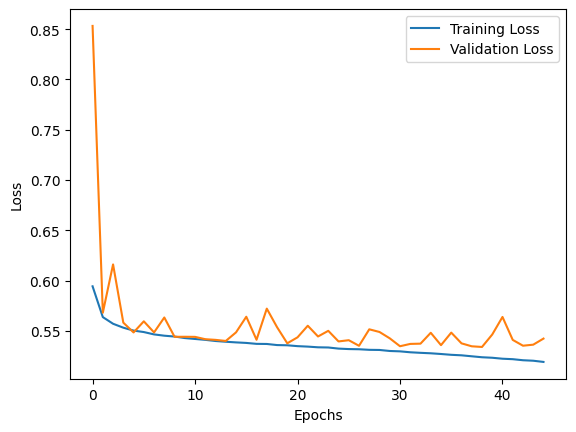

In [15]:
for i in range(1):
    plt.plot(trn_fold_loss[i], label='Training Loss')
    plt.plot(val_fold_loss[i], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()